In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import pandas as pd

In [17]:
data = pd.read_csv(r'data.csv')

##a) Data Exploration:

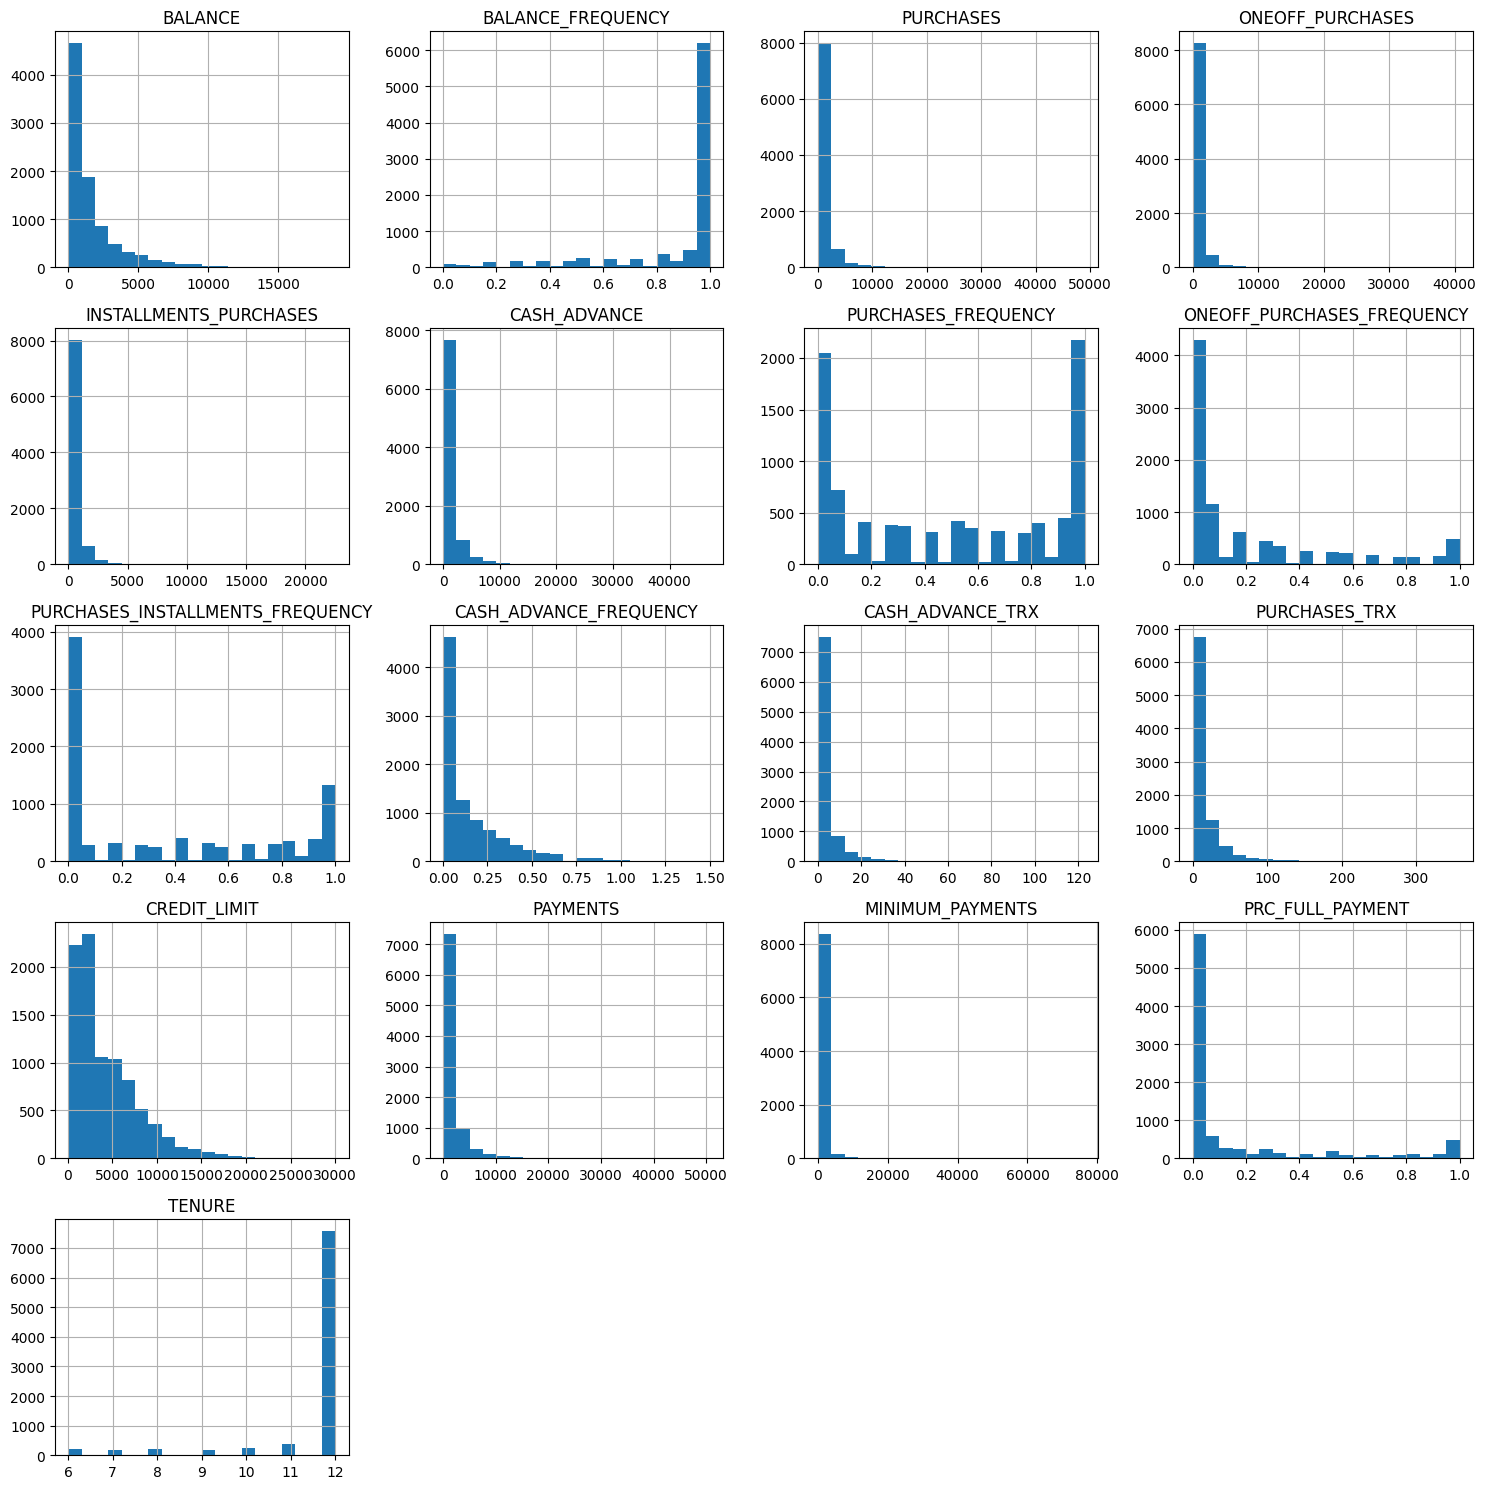

In [18]:
# Selecting columns 2-18
selected_columns = data.columns[1:]

# Plotting histograms
data[selected_columns].hist(bins=20, figsize=(15, 15))
plt.tight_layout()
plt.show()

This code will generate histograms for each of the variables from BALANCE to TENURE, providing a visual representation of the distribution of each variable.

##b) Data exploration:

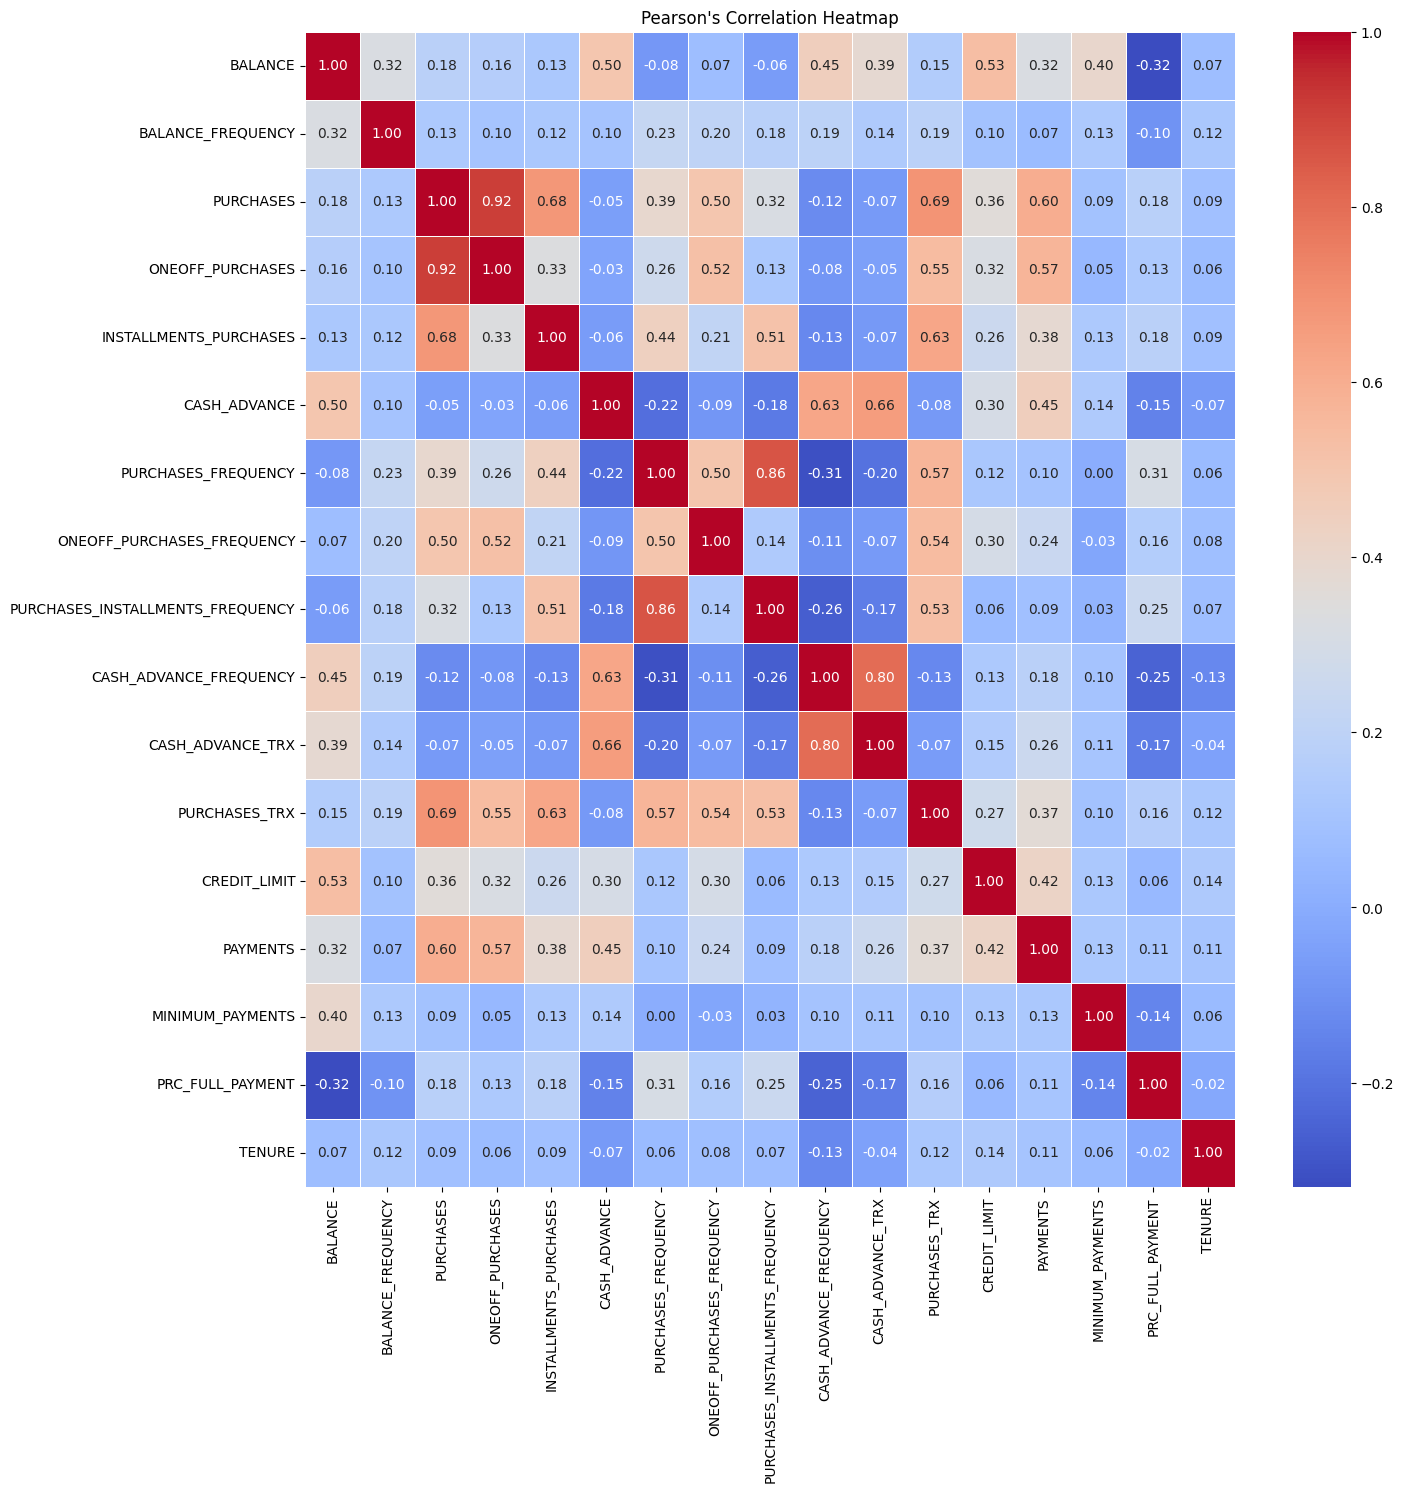

In [19]:
# Computing Pearson's correlation matrix
correlation_matrix = data[selected_columns].corr()

# Plotting heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Pearson's Correlation Heatmap")
plt.show()

This code will calculate the correlation matrix for the selected variables and then create a heatmap using the seaborn library. The heatmap provides a visual representation of the strength and direction of correlations between variables. Positive correlations are represented by warmer colors (e.g., red), while negative correlations are represented by cooler colors (e.g., blue).

After running the code, we can analyze the heatmap to identify potential associations between the variables. High positive or negative correlations suggest a strong relationship between two variables, while correlations close to zero indicate a weak or no relationship.

##c) K-Means Clustering:

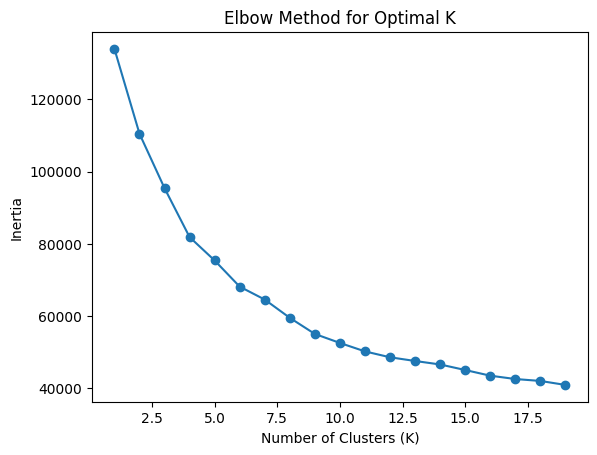

In [20]:
# Selecting columns 2-16 for clustering
features_for_clustering = data.iloc[:, 1:16]

# Standardizing the features to avoid artificially assigning higher importance to features of a larger range
scaler = StandardScaler()
features_for_clustering_scaled = scaler.fit_transform(features_for_clustering)

# Handling missing values by imputing the mean
imputer = SimpleImputer(strategy='mean')
features_for_clustering_scaled_imputed = imputer.fit_transform(features_for_clustering_scaled)

# Experiment with different values of K to find the optimal number of clusters using the elbow method
# Sum of squared distances to the closest centroid (inertia) is used for the elbow method
inertia = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(features_for_clustering_scaled_imputed)
    inertia.append(kmeans.inertia_)


# Plot the elbow method graph
plt.plot(range(1, 20), inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

In the elbow method graph, we'll look for the "elbow" point where the inertia starts to decrease at a slower rate. This point indicates a reasonable number of clusters to use.

So I choose k=5 as the optimal number of cluster based on the elbow method to perform K-Means clustering.

In [21]:
# Choosing the optimal number of clusters (K*) based on the elbow method
optimal_k = 5  # Based on your interpretation of the elbow method graph

# Handling missing values by imputing the mean
imputer = SimpleImputer(strategy='mean')
features_for_clustering_scaled_imputed = imputer.fit_transform(features_for_clustering_scaled)

# K-Means clustering with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
data['cluster'] = kmeans.fit_predict(features_for_clustering_scaled_imputed)

# Report the number of users assigned to each cluster
print("Number of users in each cluster:")
print(data['cluster'].value_counts())

# Centroid of each cluster
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=features_for_clustering.columns)
print("\nCentroid of each cluster:")
print(centroids)

# Scatter of each cluster
cluster_scatter = pd.DataFrame(index=range(optimal_k), columns=['Scatter'])
for i in range(optimal_k):
    cluster_data = features_for_clustering_scaled_imputed[data['cluster'] == i]
    cluster_scatter.loc[i, 'Scatter'] = np.mean(np.linalg.norm(cluster_data - kmeans.cluster_centers_[i], axis=1))

print("\nScatter of each cluster:")
print(cluster_scatter)


Number of users in each cluster:
0    3270
4    2959
1    1382
2     948
3     391
Name: cluster, dtype: int64

Centroid of each cluster:
       BALANCE  BALANCE_FREQUENCY    PURCHASES  ONEOFF_PURCHASES  \
0   973.106582           0.964180  1283.035595        630.240547   
1   116.199978           0.387420   339.482491        203.063939   
2  4974.996550           0.967080   568.479419        357.575850   
3  3582.786209           0.987670  7846.156240       5226.640153   
4  1535.930665           0.966456   238.801152        195.312740   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0              653.159853    238.539136             0.889303   
1              136.633469    313.736270             0.280764   
2              211.010929   5082.506594             0.313384   
3             2621.050614    623.973820             0.946935   
4               43.655601    841.303258             0.143570   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0

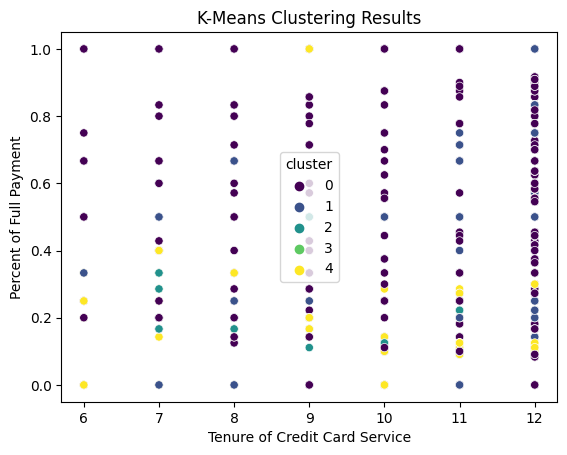

   cluster  PRC_FULL_PAYMENT     TENURE  Number_of_Users
0        0          0.252274  11.593884             3270
1        1          0.230697  11.331404             1382
2        2          0.039462  11.418776              948
3        3          0.290244  11.948849              391
4        4          0.027405  11.494086             2959


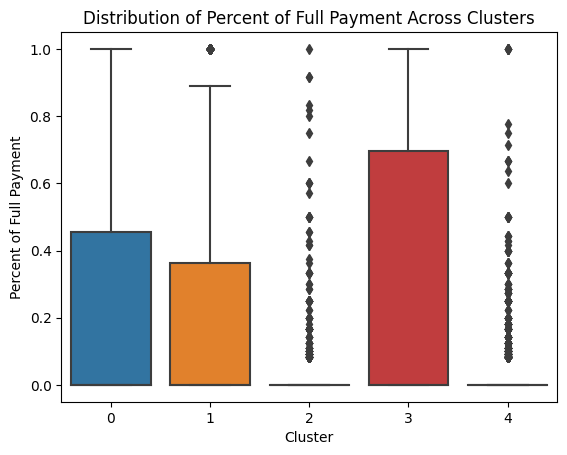

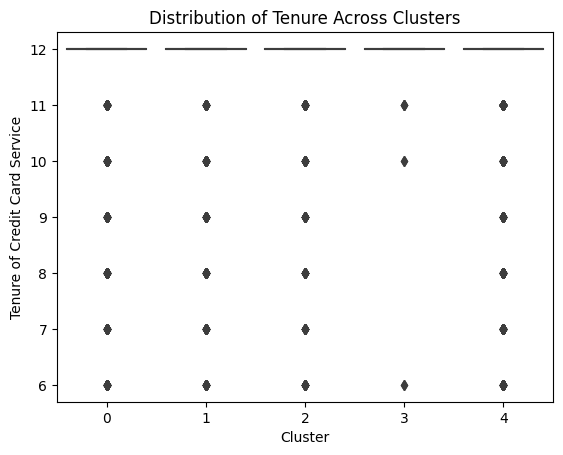

In [22]:
# Visualize the clusters
sns.scatterplot(x='TENURE', y='PRC_FULL_PAYMENT', hue='cluster', data=data, palette='viridis')
plt.title('K-Means Clustering Results')
plt.xlabel('Tenure of Credit Card Service')
plt.ylabel('Percent of Full Payment')
plt.show()

# Analyze cluster characteristics
cluster_analysis = data.groupby('cluster').agg({
    'PRC_FULL_PAYMENT': 'mean',
    'TENURE': 'mean',
    'BALANCE': 'count'  # count of users in each cluster
}).rename(columns={'BALANCE': 'Number_of_Users'}).reset_index()

# Display cluster analysis
print(cluster_analysis)

# Box plot for Percent of Full Payment
sns.boxplot(x='cluster', y='PRC_FULL_PAYMENT', data=data)
plt.title('Distribution of Percent of Full Payment Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Percent of Full Payment')
plt.show()

# Box plot for Tenure
sns.boxplot(x='cluster', y='TENURE', data=data)
plt.title('Distribution of Tenure Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Tenure of Credit Card Service')
plt.show()


Association with Percent of Full Payment (Variable 17) and Tenure (Variable 18) from cluster analysis based on mean to minimize variance within clusters:

Here we observe cluster 3 with a higher average PRC_FULL_PAYMENT, it may suggest a group of users who consistently make full payments.

Similarly, in cluster 3 there are less number of users who has higher PRC_FULL_PAYMENT and longer TENURE perioud which might indicate levels of loyalty or engagement.

      PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY
0               -0.806490                         -0.707313
1               -1.221758                         -0.916995
2                1.269843                         -0.916995
3               -1.014125                         -0.916995
4               -1.014125                         -0.916995
...                   ...                               ...
8945             1.269843                          1.179833
8946             1.269843                          1.179833
8947             0.854576                          0.760469
8948            -1.221758                         -0.916995
8949             0.439310                         -0.916995

[8950 rows x 2 columns]


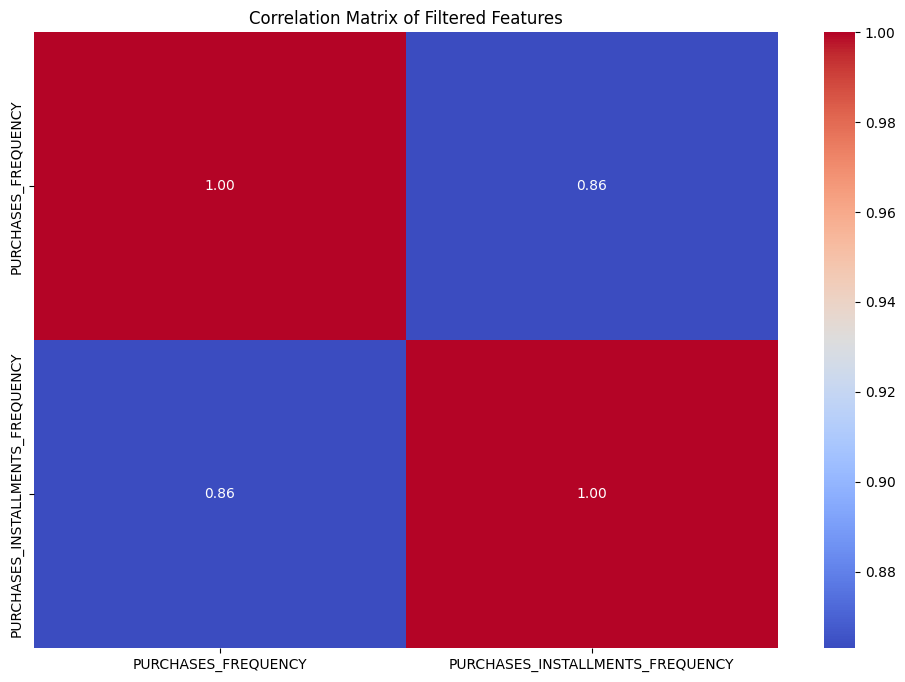

In [23]:
# Converting NumPy array to a DataFrame
features_df = pd.DataFrame(features_for_clustering_scaled_imputed, columns=features_for_clustering.columns)

# Identify highly skewed features
skewness = features_df.skew()
skewed_features = skewness[abs(skewness) > 1].index

# Remove highly skewed features
features_filtered = features_df.drop(columns=skewed_features)
print(features_filtered)

# Compute the correlation matrix for the filtered features
correlation_matrix_filtered = features_filtered.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_filtered, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Filtered Features')
plt.show()

After visualizing the correlation matrix of highly skewed features, we can choose a subset of features for K-Means clustering based on less correlated features and after removing highly skewed features.

##d) K-Means Clustering:

In [24]:
# Converting the NumPy array to a DataFrame
features_df = pd.DataFrame(features_for_clustering_scaled_imputed, columns=features_for_clustering.columns)

# Choosing a subset of features based on your findings from the correlation matrix heatmap
selected_features = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS']

# Selecting the chosen features for clustering
features_selected = features_df[selected_features]

# Perform K-Means clustering with the chosen number of clusters
kmeans_selected = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
data['cluster_selected'] = kmeans_selected.fit_predict(features_selected)

# Number of users assigned to each cluster
print("Number of users in each cluster (using selected features):")
print(data['cluster_selected'].value_counts())

# Reverse scaling for centroids
centroids_selected_original = pd.DataFrame(
    kmeans_selected.cluster_centers_ * scaler.scale_[:features_selected.shape[1]] + scaler.mean_[:features_selected.shape[1]],
    columns=features_selected.columns
)

print("\nCentroid of each cluster (using selected features):")
print(centroids_selected_original)

# Scatter of each cluster
cluster_scatter_selected = pd.DataFrame(index=range(optimal_k), columns=['Scatter'])
for i in range(optimal_k):
    cluster_data_selected = features_selected[data['cluster_selected'] == i]
    cluster_scatter_selected.loc[i, 'Scatter'] = np.mean(np.linalg.norm(cluster_data_selected - kmeans_selected.cluster_centers_[i], axis=1))

print("\nScatter of each cluster (using selected features):")
print(cluster_scatter_selected)


Number of users in each cluster (using selected features):
0    3510
1    2916
4    1372
2    1030
3     122
Name: cluster_selected, dtype: int64

Centroid of each cluster (using selected features):
       BALANCE  BALANCE_FREQUENCY     PURCHASES  CASH_ADVANCE  \
0   928.818307           0.968427   1540.992846     22.182361   
1  1411.634529           0.964998    206.658340    526.994138   
2  5683.058107           0.976932   1034.708972   3018.152350   
3  4908.110024           0.927894  11560.238607   3616.744540   
4   122.209212           0.377856    357.438796     98.308948   

   PURCHASES_FREQUENCY  CREDIT_LIMIT  PAYMENTS  MINIMUM_PAYMENTS  
0          1298.173697    946.719502  0.469981          0.164446  
1          -388.529073    121.094282  0.382210          0.177819  
2           177.651939   3634.147516  0.728332          0.477658  
3          1106.451729   5721.451318  2.757247          0.407107  
4           -45.754733    466.795717  0.391821          0.127016  

Scatter

My Correlation threshold is 0.6 based on part b) Data Exploration, features greater than correlation factor greater than 0.6 is dropped.

1) Removing ONEOFF_PURCHASES as it's highly correlated with PURCHASES.

2) Removing INSTALLMENTS_PURCHASES as it's highly correlated with PURCHASES.

3) Removing PURCHASES_INSTALLMENTS_FREQUENCY as it's highly correlated with PURCHASES_FREQUENCY.

4) Removing CASH_ADVANCE_FREQUENCY as it's highly correlated with CASH_ADVANCE.

5) Removing CASH_ADVANCE_TRX as it's highly correlated with CASH_ADVANCE.

6) Removing PURCHASES_TRX as it's highly correlated with PURCHASES.


##e) Gaussian mixture models:

Number of users in each GMM cluster:
0    2527
2    2149
1    1925
4    1491
3     858
Name: cluster_gmm, dtype: int64

Mean vector for each Gaussian in GMM:
[[-0.3428768   0.51808382  0.17127476 -0.46678555  0.69075397 -0.01526038
  -0.15478343 -0.21920991]
 [ 0.23078162  0.01872967 -0.46955188  0.42017363 -1.22175806 -0.16870673
  -0.11507963 -0.07896894]
 [ 0.61963046  0.51808382  0.01983123  0.2266228   0.25839672  0.10630547
   0.03384864  0.47823749]
 [ 0.1902532  -0.40784679  0.86792746  0.66489724  0.07918679  0.46877231
   1.24170881  0.10970976]
 [-0.72409617 -1.40710919 -0.21380625 -0.46678555 -0.00778423 -0.18139651
  -0.35783029 -0.28293395]]

Covariance matrices for each Gaussian in GMM (visualized with heatmap):


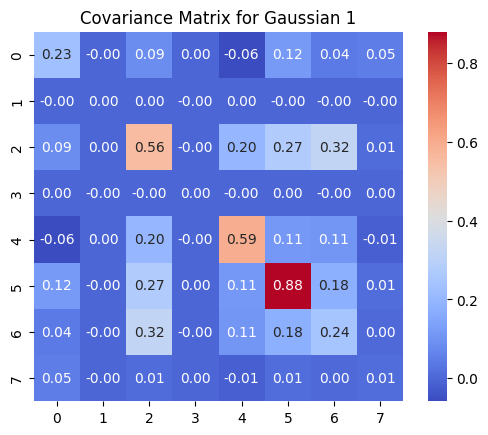

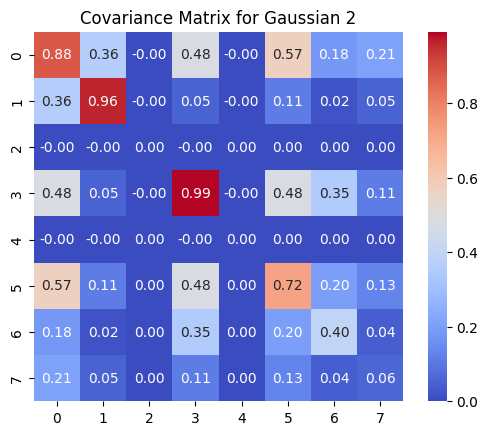

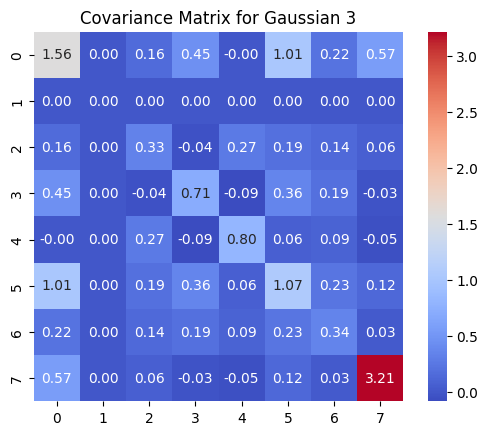

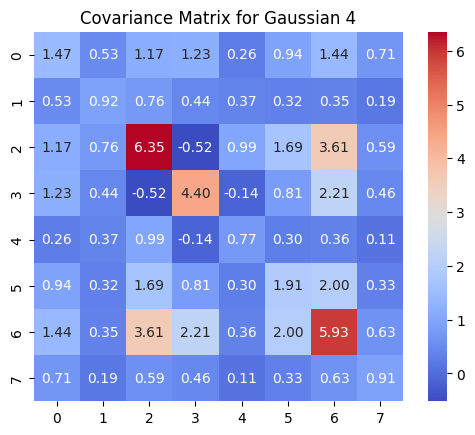

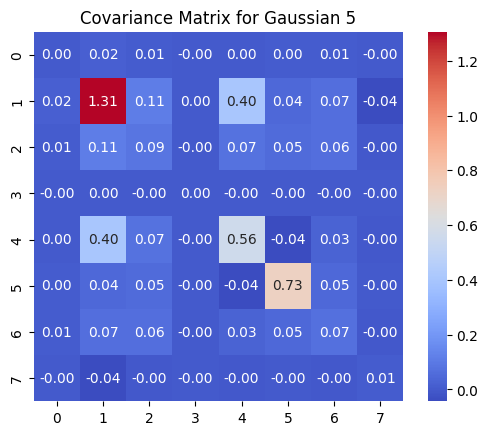

[  4.60881863   5.9208369    7.58886651 ...   5.92834608   7.99235041
 -11.86741202]


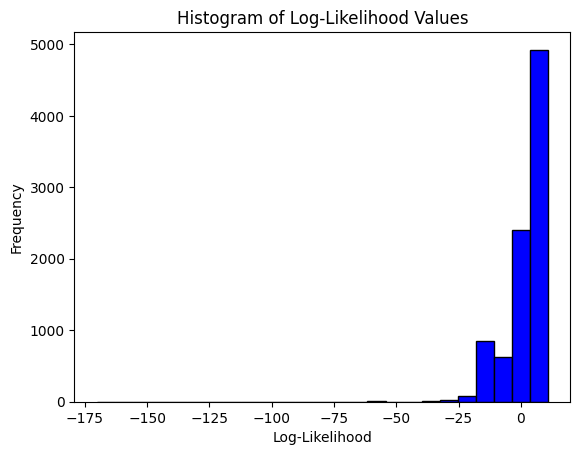

In [25]:
# Features for GMM clustering
features_gmm = features_selected

# The optimal number of components (Gaussians) based on K*
n_components_gmm = optimal_k

# Gaussian Mixture Model
gmm = GaussianMixture(n_components=n_components_gmm, random_state=42)
data['cluster_gmm'] = gmm.fit_predict(features_gmm)

# Number of users assigned to each GMM cluster
print("Number of users in each GMM cluster:")
print(data['cluster_gmm'].value_counts())

# The mean vector and covariance matrix for each Gaussian in GMM
print("\nMean vector for each Gaussian in GMM:")
print(gmm.means_)

print("\nCovariance matrices for each Gaussian in GMM (visualized with heatmap):")
for i in range(n_components_gmm):
    sns.heatmap(gmm.covariances_[i], annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title(f"Covariance Matrix for Gaussian {i + 1}")
    plt.show()

# log-likelihood of each sample belonging to the GMM
log_likelihood = gmm.score_samples(features_gmm)
print(log_likelihood)

# Histogram plot of log-likelihood values
plt.hist(log_likelihood, bins=25, color='blue', edgecolor='black')
plt.title('Histogram of Log-Likelihood Values')
plt.xlabel('Log-Likelihood')
plt.ylabel('Frequency')
plt.show()

Mean Vector: The mean vector for each Gaussian represents the centroid of the cluster in the feature space.

Covariance Matrices: The heatmaps visualize the spread and correlation among features within each cluster. Patterns in the covariance matrices reveals the shape and orientation of the clusters.

Log-Likelihood: The log-likelihood indicates how well each sample fits the GMM. Higher log-likelihood values suggest better fit.

Histogram of Log-Likelihood: Examining the histogram helps identify the distribution of fit quality across all samples. In the above model for most of the samples log-likelihood is high signifies the goodness of fit of the GMM to the data.